In [1]:
## collab user
# !pip install neuron
# !pip install netpyne
# !git clone https://github.com/suny-downstate-medical-center/S1_netpyne.git
# import os
# os.chdir('S1_netpyne/info')

In [2]:
import matplotlib
import os
os.chdir('../sim')

In [3]:
!nrnivmodl mod/

/home/fernando/S1_netpyne/sim
Mod files: "mod/cadad.mod" "mod/CaDynamics_E2.mod" "mod/Ca_HVA.mod" "mod/Ca_LVAst.mod" "mod/Ca.mod" "mod/DetAMPANMDA.mod" "mod/DetGABAAB.mod" "mod/HH2.mod" "mod/htc.mod" "mod/Ih.mod" "mod/Im.mod" "mod/IT2.mod" "mod/IT.mod" "mod/KdShu2007.mod" "mod/kl.mod" "mod/K_Pst.mod" "mod/K_Tst.mod" "mod/MyExp2SynBB.mod" "mod/MyExp2SynNMDABB.mod" "mod/Nap_Et2.mod" "mod/NaTa_t.mod" "mod/NaTs2_t.mod" "mod/ProbAMPANMDA_EMS.mod" "mod/ProbGABAAB_EMS.mod" "mod/SK_E2.mod" "mod/SKv3_1.mod" "mod/StochKv_deterministic.mod" "mod/StochKv.mod" "mod/tia.mod"

COBJS=''
 -> Compiling mod_func.c
gcc -O2   -I.   -I/home/fernando/anaconda3/envs/netpynedev/lib/python3.7/site-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.so
g++ -O2 -DVERSION_INFO='8.0.0' -std=c++11 -shared -fPIC  -I /home/fernando/anaconda3/envs/netpynedev/lib/python3.7/site-packages/neuron/.data/include -o ./libnrnmech.so -Wl,-soname,li

In [4]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs, sim
import pickle, json
import numpy as np

%matplotlib inline

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 2.0*1e2 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'conn': 4321, 'stim': 4321, 'loc': 4323} 
cfg.hParams = {'celsius': 34, 'v_init': -35}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True

cfg.checkErrors = False

cfg.poptypeNumber = 61 # max 55 + 6
cfg.celltypeNumber = 213 # max 207 + 6

In [5]:
#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop
with open('../info/anatomy/S1-cells-distributions-Rat.txt') as mtype_file:
	mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
popParam = []
cellParam = []
cfg.meParamLabels = {} 
for line in mtype_content.split('\n')[:-1]:
	metype, mtype, etype, n, m = line.split()
	cfg.cellNumber[metype] = int(n)
	cfg.popLabel[metype] = mtype
	cfg.popNumber[mtype] = int(m)

	if mtype not in popParam:
		popParam.append(mtype)
	cellParam.append(metype)

cfg.S1pops = popParam[0:55]
cfg.S1cells = cellParam[0:207]

#------------------------------------------------------------------------------  
# Thalamic Cells

cfg.thalamicpops = ['ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1']

cfg.cellNumber['ss_RTN_o'] = int(382 * (210**2/150**2))
cfg.cellNumber['ss_RTN_m'] = int(382 * (210**2/150**2))
cfg.cellNumber['ss_RTN_i'] = int(765 * (210**2/150**2))
cfg.cellNumber['VPL_sTC'] = int(656 * (210**2/150**2))
cfg.cellNumber['VPM_sTC'] = int(839 * (210**2/150**2))
cfg.cellNumber['POm_sTC_s1'] = int(685 * (210**2/150**2))

for mtype in cfg.thalamicpops: # No diversity
	metype = mtype
	popParam.append(mtype)
	cfg.popLabel[metype] = mtype
	cellParam.append(metype)

	cfg.popNumber[mtype] = cfg.cellNumber[metype]

#------------------------------------------------------------------------------  
cfg.popParamLabels = popParam[0:cfg.poptypeNumber] # to debug
cfg.cellParamLabels = cellParam[0:cfg.celltypeNumber] # to debug

In [6]:
#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------

# TO DEBUG - import and simulate only the Cell soma (to study only the Net)
cfg.reducedtest = True    

# TO DEBUG - Create only 5 Cells for each MEtype in S1
cfg.oneCellperMEtypeS1 = False 

In [7]:
#------------------------------------------------------------------------------  
# TO DEBUG - Create only one Cell per MEtype in S1 cells
if cfg.oneCellperMEtypeS1:
	cfg.popNumber = {}
	cfg.cellNumber = {} 
	for mtype in cfg.S1pops:
		cfg.popNumber[mtype] = 0

	for line in mtype_content.split('\n')[:-1]:
		metype, mtype, etype, n, m = line.split()
		if int(n) < 5:
			cfg.cellNumber[metype] = int(n)
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + int(n)
		else:
			cfg.cellNumber[metype] = 5
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + 5


In [8]:
# testpop = ['L4_SS', 'L5_STPC', 'L5_UTPC', 'L23_LBC', 'L23_MC', 'L4_LBC', 'L4_MC', 'L5_LBC', 'L5_MC']
# Nsyn=513042, N=2684

In [9]:
# subPopLabels = ['L1_DLAC', 'L23_PC', 'L4_SBC', 'L6_TPC_L4']
# cfg.S1pops = subPopLabels
# cfg.S1cells = ['L1_DLAC_cNAC187', 'L23_PC_cADpyr229', 'L4_SBC_bNAC219', 'L6_TPC_L4_cADpyr231']

# cfg.thalamicpops = []

# cfg.popParamLabels = cfg.S1pops
# cfg.cellParamLabels = cfg.S1cells
# for metype in cfg.cellParamLabels:
#     if cfg.popLabel[metype] in subPopLabels:
#         cfg.popNumber[cfg.popLabel[metype]] = 5
#         print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])        

In [10]:
#------------------------------------------------------------------------------  
# cfg.S1pops = subPopLabels
# cfg.S1cells = []
# for metype in cfg.cellParamLabels:
#     if cfg.popLabel[metype] in subPopLabels:        
#         cfg.S1cells.append(metype)
        
# cfg.thalamicpops = []

# cfg.popParamLabels = cfg.S1pops
# cfg.cellParamLabels = cfg.S1cells

In [11]:
#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.popParamLabels
cfg.cellsrec = 0
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells

cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = False
cfg.recordTime = False
cfg.recordStep = 0.1    

In [12]:
#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'subNets_test0'
cfg.saveFolder = '../info/test/'+cfg.simLabel
# cfg.filename =                	## Set file output name
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False	           	## Save json file
cfg.saveDataInclude = ['simConfig','simData'] ## , 'netParams', 'simConfig', 
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = False			
cfg.saveCellConns = False	

In [13]:
"""
netParams.py
"""
# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

netParams.scale = 1.0 # Scale factor for number of cells
netParams.sizeX = 420.0 # x-dimension (horizontal length) size in um
netParams.sizeY = 2082.0 # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 20.0 # z-dimension (horizontal depth) size in um
netParams.shape = 'cuboid' # cylindrical (column-like) volume

# r = 210 um and hexagonal side length = 230.9 um

In [14]:
#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
# Layer	height (um)	height (norma)	from	to
# L1	165		    0.079		    0.000	0.079
# L2	149		    0.072		    0.079	0.151
# L3	353		    0.170		    0.151	0.320
# L4	190		    0.091		    0.320	0.412
# L5	525		    0.252		    0.412	0.664
# L6	700		    0.336		    0.664	1.000
# L23	502		    0.241		    0.079	0.320
# All	2082	    1.000	


cellModels = ['HH_full']
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
Ipops = []
for popName in cfg.S1pops:
    if popName not in Epops:
        Ipops.append(popName)

Epops = []
for popName in cfg.S1pops:
    if popName not in Ipops:
        Epops.append(popName)   

layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries

#Th pop
ymin={'ss_RTN_o': 1000+1688, 'ss_RTN_m': 1000+1766, 'ss_RTN_i': 1000+1844, 'VPL_sTC': 1000+2000, 'VPM_sTC': 1000+2156, 'POm_sTC_s1': 1000+2312}
ymax={'ss_RTN_o': 1000+1766, 'ss_RTN_m': 1000+1844, 'ss_RTN_i': 1000+2000, 'VPL_sTC': 1000+2156, 'VPM_sTC': 1000+2312, 'POm_sTC_s1': 1000+2624}


In [15]:
#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
## S1
cfg.scaleDensity = 1.0

for popName in cfg.S1pops:
	layernumber = popName[1:2]
	if layernumber == '2':
		netParams.popParams[popName] = {'cellType': popName, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.popNumber[popName])), 'diversity': True}
	else:
		netParams.popParams[popName] = {'cellType': popName, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.popNumber[popName])), 'diversity': True}

## THALAMIC POPULATIONS (from prev model)
for popName in cfg.thalamicpops:
    if 'RTN' in popName: # inhibitory - RTN
        ThcellType = 'sRE_cell'
    else: # excitatory
        ThcellType = 'sTC_cell'    
    netParams.popParams[popName] = {'cellType': ThcellType, 'cellModel': 'HH_full', 'yRange': [ymin[popName], ymax[popName]],
                                        'numCells':  int(np.ceil(cfg.scaleDensity*cfg.popNumber[popName])), 'diversity': False}

In [16]:
## S1 cell property rules
cellnumber = 0    
for cellName in cfg.S1cells:
    
    if cfg.cellNumber[cellName] < 5:
        morphoNumbers = cfg.cellNumber[cellName]
    else:
        morphoNumbers = 5
    
    popName = cfg.popLabel[cellName]
    cellFraction = 1.0*cfg.cellNumber[cellName]/(morphoNumbers*cfg.popNumber[popName])
    
    for morphoNumber in range(morphoNumbers):
        cellMe = cellName + '_' + str(morphoNumber+1)
        ## Load cell rules previously saved using netpyne format
        netParams.loadCellParamsRule(label = cellMe, fileName = 'cell_data/' + cellMe + '/' + cellMe + '_cellParams.pkl')    
        netParams.renameCellParamsSec(label = cellMe, oldSec = 'soma_0', newSec = 'soma')

        cellRule = {'conds': {'cellType': popName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
        cellRule['secs'] = netParams.cellParams[cellMe]['secs']     
        cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
        cellRule['conds']['cellType'] = popName
        cellRule['globals'] = netParams.cellParams[cellMe]['globals']       
        cellRule['secLists'] = netParams.cellParams[cellMe]['secLists']                 
        cellRule['secLists']['all'][0] = 'soma' # replace 'soma_0'
        cellRule['secLists']['somatic'][0]  = 'soma' # replace 'soma_0'
                              
        cellRule['secLists']['spiny'] = {}
        cellRule['secLists']['spinyEE'] = {}

        nonSpiny = ['axon_0', 'axon_1']
        cellRule['secLists']['spiny'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpiny]
        nonSpinyEE = ['axon_0', 'axon_1', 'soma']
        cellRule['secLists']['spinyEE'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpinyEE]

        #-----------------------------------------------------------------------------------#
        if cfg.reducedtest:
            cellRule['secs'] = {}
            cellRule['secs']['soma'] = netParams.cellParams[cellMe]['secs']['soma']
            cellRule['secLists']['spiny'] = ['soma']
            cellRule['secLists']['spinyEE'] = ['soma']
            cellRule['secLists']['all'] = ['soma']
            cellRule['secLists']['basal'] = ['soma']    
        #-----------------------------------------------------------------------------------#
        netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params   
        cellnumber=cellnumber+1

In [17]:
## Th cell property rules
# JSON FILES FROM A1 WITH UPDATED DYNAMICS
# # --- VL - Exc --- #
netParams.loadCellParamsRule(label='sTC_cell', fileName='cells/sTC_jv_00.json')  # Load cellParams for each of the above cell subtype
netParams.cellParams['sTC_cell']['conds']={}

# --- RTN - Inh --- #
netParams.loadCellParamsRule(label='sRE_cell', fileName='cells/sRE_jv_00.json')  # Load cellParams for each of the above cell subtype
netParams.cellParams['sRE_cell']['conds']={}

## Run small Nets in a sigle job

In [18]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
# sim.net.connectCells()            			# create connections between cells based on params
# sim.net.addStims() 							# add network stimulation
# sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
# sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
# sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
# sim.analysis.plotData()  


Start time:  2021-08-12 22:23:30.808594

Creating network of 61 cell populations on 1 hosts...
  Number of cells on node 0: 38612 
  Done; cell creation time = 85.80 s.

Gathering data...
  Done; gather time = 1.52 s.

Analyzing...
  Cells: 38612
  Connections: 0 (0.00 per cell)


{spkt: {}, _repr_mimebundle_: {}}

## Net infos

In [19]:
# subPopLabels
cfg.thalamicpops
cfg.S1pops

['L1_DAC',
 'L1_DLAC',
 'L1_HAC',
 'L1_NGC-DA',
 'L1_NGC-SA',
 'L1_SLAC',
 'L23_BP',
 'L23_BTC',
 'L23_ChC',
 'L23_DBC',
 'L23_LBC',
 'L23_MC',
 'L23_NBC',
 'L23_NGC',
 'L23_PC',
 'L23_SBC',
 'L4_BP',
 'L4_BTC',
 'L4_ChC',
 'L4_DBC',
 'L4_LBC',
 'L4_MC',
 'L4_NBC',
 'L4_NGC',
 'L4_PC',
 'L4_SBC',
 'L4_SP',
 'L4_SS',
 'L5_BP',
 'L5_BTC',
 'L5_ChC',
 'L5_DBC',
 'L5_LBC',
 'L5_MC',
 'L5_NBC',
 'L5_NGC',
 'L5_SBC',
 'L5_STPC',
 'L5_TTPC1',
 'L5_TTPC2',
 'L5_UTPC',
 'L6_BPC',
 'L6_BP',
 'L6_BTC',
 'L6_ChC',
 'L6_DBC',
 'L6_IPC',
 'L6_LBC',
 'L6_MC',
 'L6_NBC',
 'L6_NGC',
 'L6_SBC',
 'L6_TPC_L1',
 'L6_TPC_L4',
 'L6_UTPC']

Plotting 2D representation of network cell locations and connections...


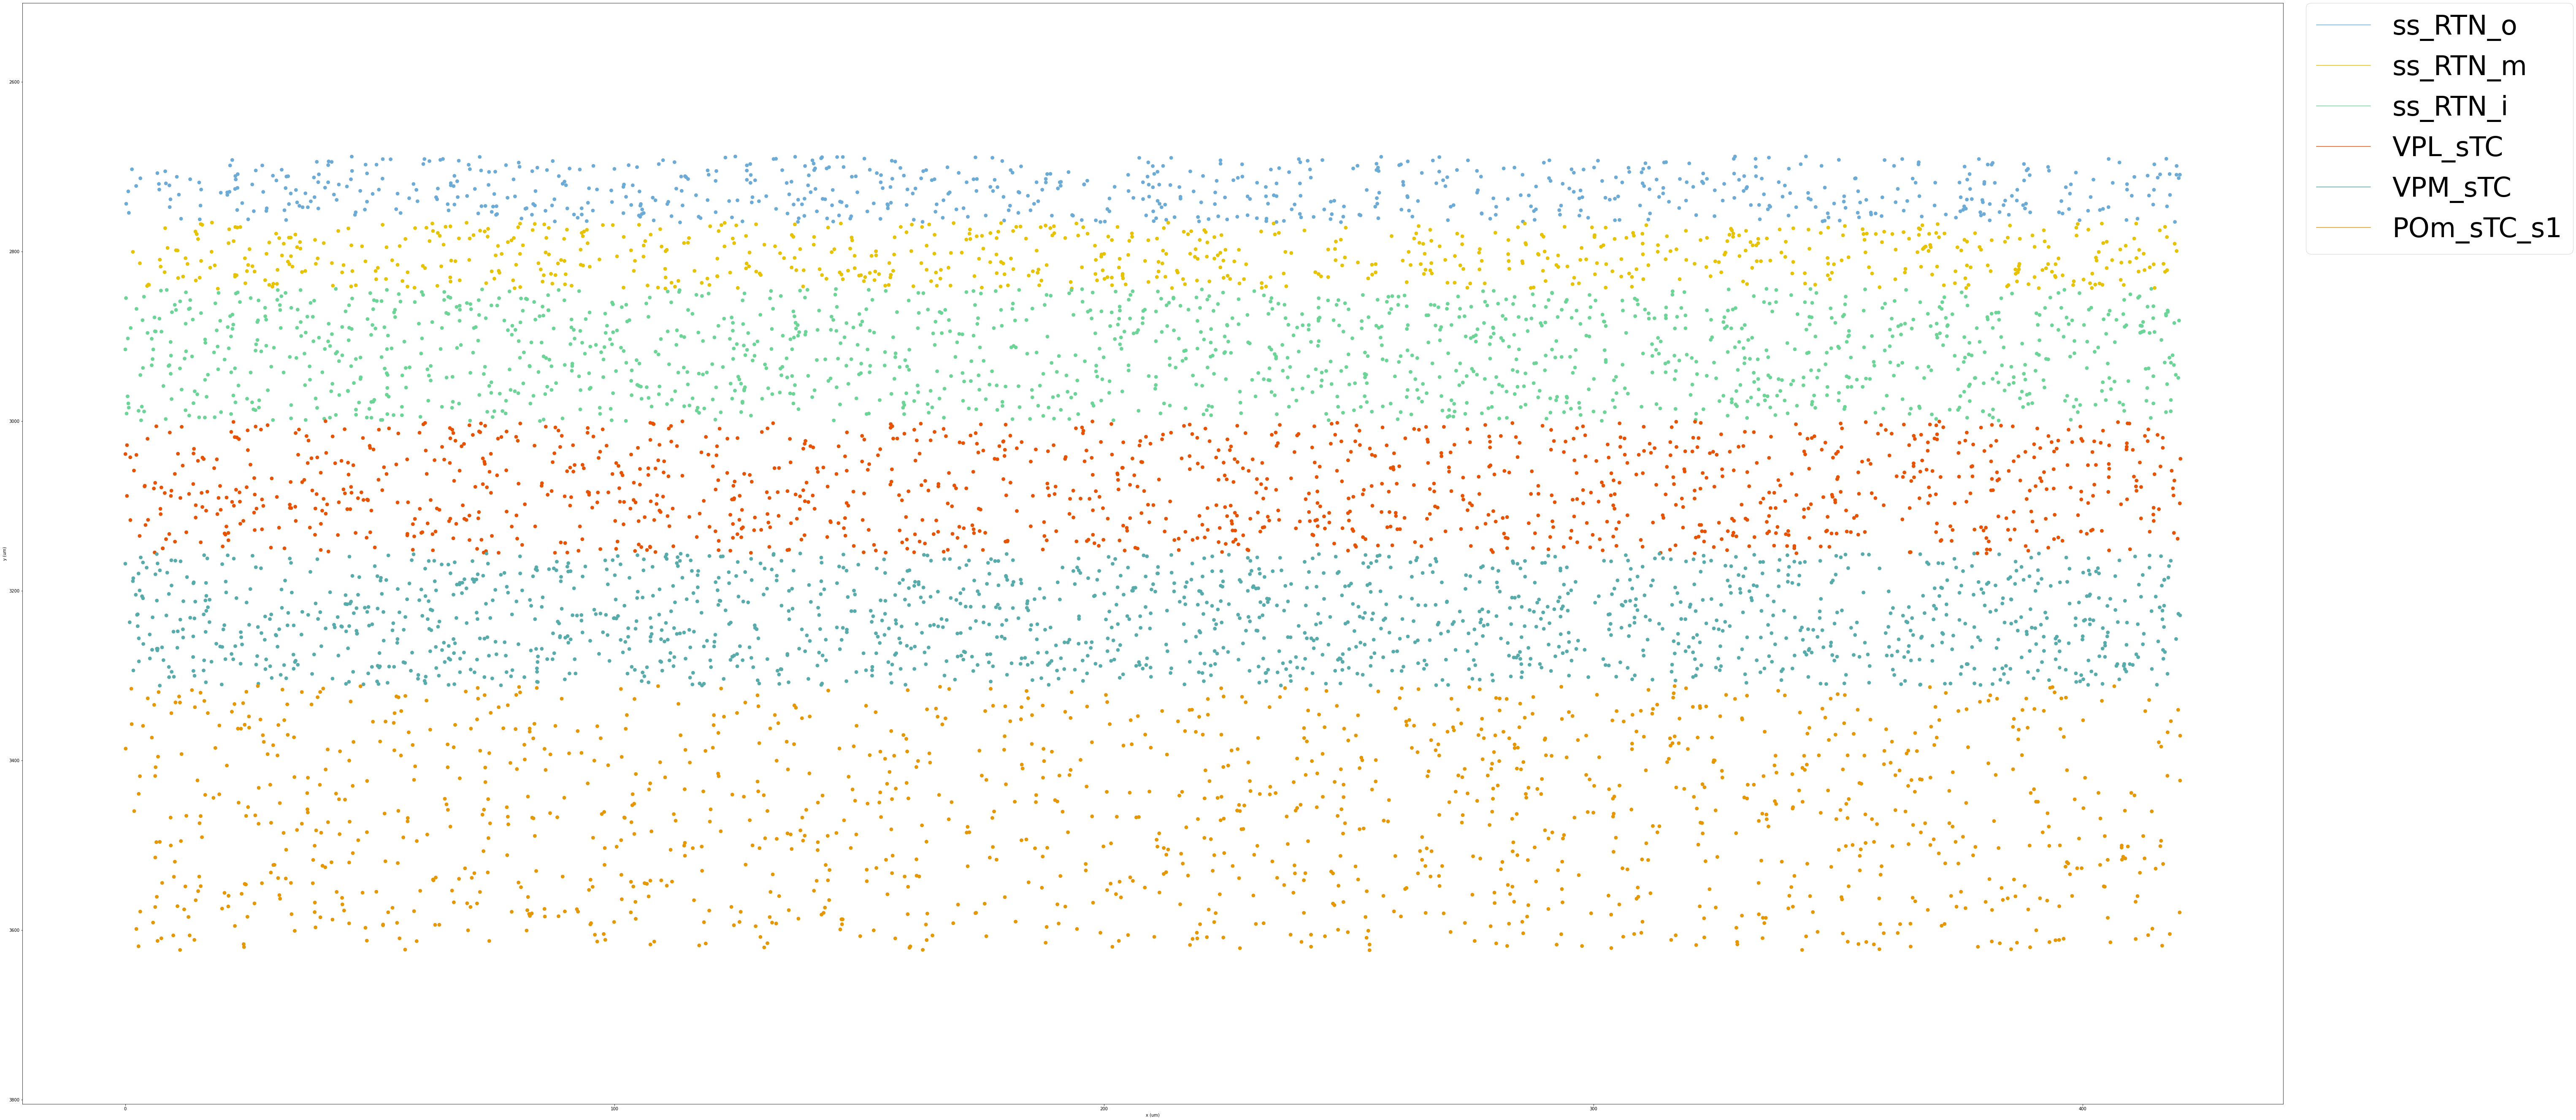

In [24]:
sim.analysis.plot2Dnet(include= ['ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1'],view='xy', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(96, 48), fontSize=64, saveData=None, 
                               saveFig=True, showFig=True, lineWidth=0.1);

In [21]:
subPopLabels

NameError: name 'subPopLabels' is not defined

In [ ]:
sim.analysis.plotShape(showFig=True, includeAxon=False, showSyns=False, dist= 0.65, cvar= 'voltage', axis='off',saveFig=True, figSize=(24,24), dpi= 600)

# cfg.analysis['plotShape'] = {'includePre': cfg.cellsrecShape, 'includePost': cfg.cellsrecShape, 'showFig': False, 'includeAxon': False, 
#                             'showSyns': False, 'saveFig': True, 'dist': 0.55, 'cvar': 'voltage', 'figSize': (24,12), 'dpi': 600}

In [ ]:
import math
import sys
from matplotlib import pyplot as plt

max_prob=1

# conn_thresh=100
# conn_thresh_list=[264.63]
conn_thresh_list=[64.33, 95.75, 97.67, 102.49, 103.57, 149.31, 264.63]
# conn_thresh_list=[49.1, 73.3, 75.4]
# conn_thresh_list=[99.61, 106.12, 163.58 ]

# l_list=[25, 50, 100, 200, 500]
l_list=[100]
# l_list=range(25,501,25)
max_dist=500
dist_list=range(-max_dist,max_dist,1)

step = 1
steprange = range(0,len(conn_thresh_list),step)
color_map = plt.get_cmap('spring')
colors = [color_map(1.*i/float((len(steprange)))) for i in range(len(steprange))]

for l in l_list:
    conn_prob_list=[]
    for dist_2D in dist_list:
        conn_prob = max_prob*math.exp(-abs(dist_2D)/l)
        conn_prob_list.append(conn_prob)
    plt.plot(dist_list,conn_prob_list,color='red',linestyle=':',lineWidth=1)
    
    for i,conn_thresh in enumerate(conn_thresh_list):
        conn_prob_list_thresh=[]
        for dist_2D in dist_list:
            conn_prob = max_prob*math.exp(-abs(dist_2D)/l)
            if abs(dist_2D)>conn_thresh:
                conn_prob_list_thresh.append(0)
            else:
                conn_prob_list_thresh.append(conn_prob)
        plt.plot(dist_list,conn_prob_list_thresh,linewidth=1.5, color=colors[i])
plt.grid()
# plt.savefig('')
plt.xlim([-max_dist,max_dist])
plt.ylim([0,1.1])
plt.yticks([0,0.25,0.5,0.75,1.0])

####################################################################################

plt.figure()

max_prob=0.75

conn_thresh_list=[64.33, 95.75, 97.67, 102.49, 103.57, 149.31, 264.63]
max_dist=500
dist_list=range(-max_dist,max_dist,1)

step = 1
steprange = range(0,len(conn_thresh_list),step)
color_map = plt.get_cmap('spring')
colors = [color_map(1.*i/float((len(steprange)))) for i in range(len(steprange))]

# conn_prob_list=[]
# for dist_2D in dist_list:
#     conn_prob = max_prob*math.exp(-abs(dist_2D)/(l/2))
#     conn_prob_list.append(conn_prob)
# plt.plot(dist_list,conn_prob_list,color='red',linestyle=':',lineWidth=1)

for i,conn_thresh in enumerate(conn_thresh_list):
    conn_prob_list_thresh=[]
    for dist_2D in dist_list:
        conn_prob = max_prob*math.exp(-abs(dist_2D)/(conn_thresh/2))
        if abs(dist_2D)>conn_thresh:
            conn_prob_list_thresh.append(0)
        else:
            conn_prob_list_thresh.append(conn_prob)
    plt.plot(dist_list,conn_prob_list_thresh,linewidth=1.5, color=colors[i])
plt.grid()
# plt.savefig('')
plt.xlim([-max_dist,max_dist])
plt.ylim([0,1.1])
plt.yticks([0,0.25,0.5,0.75,1.0])
plt.show()